In [44]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio
from web_app.utils import char_to_num

In [46]:
print('GPUs available: ', tf.config.list_physical_devices('GPU'))

GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [47]:
# Enabling a GPU for processing if one is available:
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [48]:
import gdown

In [49]:
# Downloading the dataset:

url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [9]:
# Extracting the frames from a video in a grayscale format and cropping to a specific region:
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    # Normalizing the frames tensor:
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std


In [1]:
# Creating a vocabulary of characters and numbers:
vocab = [x for x in "abcdefgihjklmnopqrstuvwxyz'?!123456789 "]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']


In [5]:
# Creating lookup converter methods for numbers and characters:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f'The vocabulary is: {char_to_num.get_vocabulary()}'
      f'(size={char_to_num.vocabulary_size()})')

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'i', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size=40)


In [11]:
# Loading alignments for the frames:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1))[1:])

In [5]:
# Loading the data:
def load_data(path):
    path = bytes.decode(path.numpy())
    file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames,  alignments

In [6]:
test_path = os.path.join('data', 's1', 'bbal6n.mpg')

In [7]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'data/s1/bbal6n.mpg'>

In [ ]:
load_data(tf.convert_to_tensor(test_path))

In [17]:
# Extracting the name of a file for testing:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')
os.path.splitext(os.path.basename(test_path))[0]

'bbal6n'

In [15]:
# Getting the frames and alignments paths:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [18]:
print(frames.shape)

(75, 46, 140, 1)


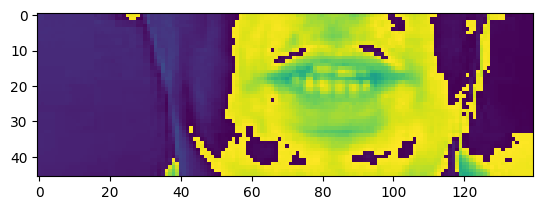

In [19]:
plt.imshow(frames[40])

In [61]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
def mappable_function(path:str):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

### Building the Data Pipeline ###

In [86]:
data = tf.data.Dataset.list_files(os.path.join('.', 'data', 's1', '*.mpg'))
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(batch_size=2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

# Splitting the data:
train = data.take(450)
test = data.skip(450)

In [88]:
len(train)

450

In [87]:
len(test)

50

In [64]:
frames, alignments = data.as_numpy_iterator().next()

In [65]:
len(frames)

2

In [66]:
test = data.as_numpy_iterator()
val = test.next(); val[0]

array([[[[[1.4243459 ],
          [1.4243459 ],
          [1.4243459 ],
          ...,
          [0.2921735 ],
          [0.2556518 ],
          [0.2556518 ]],

         [[1.4243459 ],
          [1.4243459 ],
          [1.4243459 ],
          ...,
          [0.2921735 ],
          [0.2556518 ],
          [0.2556518 ]],

         [[1.4608675 ],
          [1.4608675 ],
          [1.4243459 ],
          ...,
          [0.32869518],
          [0.2921735 ],
          [0.2921735 ]],

         ...,

         [[0.94956386],
          [0.94956386],
          [0.94956386],
          ...,
          [9.276508  ],
          [9.276508  ],
          [9.276508  ]],

         [[0.94956386],
          [0.94956386],
          [0.94956386],
          ...,
          [0.        ],
          [9.276508  ],
          [9.276508  ]],

         [[0.94956386],
          [0.94956386],
          [0.94956386],
          ...,
          [0.        ],
          [9.276508  ],
          [9.239987  ]]],


        [[[1.3878

In [67]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.313030242919922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.313030242919922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.313030242919922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.313030242919922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.313030242919922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.313030242919922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.313030242919922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

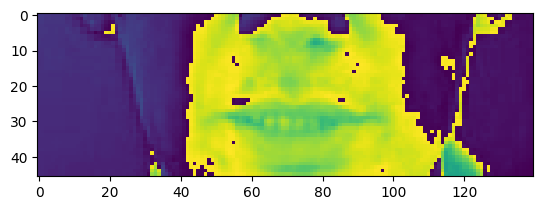

In [68]:
# First index: return videos
# Second index: return the first video out of the batch
# Third index: return the first frame in the video
plt.imshow(val[0][0][35])

In [69]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green in o eight please'>

### Building the Deep Neural Network ###

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [71]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(rate=.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(rate=.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [73]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [74]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0], axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'1jjjj8999999888889999999999999999999999888888888888888888888888888888888888'>

In [75]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'1jjjj8999999888889999999999999999999999888888888888888888888888888888888888'>

In [76]:
model.input_shape

(None, 75, 46, 140, 1)

In [77]:
model.output_shape

(None, 75, 41)

In [78]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [79]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [80]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original: ', tf.strings.reduce_join([vocab[word] + ' ' for word in data[1][x]]).numpy().decode('utf-8'))
            print('Prediction: ', tf.strings.reduce_join([vocab[word] + ' ' for word in decoded[x]]).numpy().decode('utf-8'))
            print('~' * 100)

In [81]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [82]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

In [83]:
schedule_callback = LearningRateScheduler(scheduler)

In [84]:
example_callback = ProduceExample(data)

In [89]:
## Training the model:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [90]:
# Downloading pre-trained model checkpoints:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /Users/azizimanov/Desktop/Machine Learning/Projects/LipReading/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:27<00:00, 3.39MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [91]:
# Loading the pre-trained parameters into the model:
model.load_weights('models/checkpoint')

In [92]:
test_data = test.as_numpy_iterator()

In [109]:
sample = test_data.next()

In [110]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [111]:
# Decoding the prediction with CTC:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()

In [112]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue at v four please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay whte at l four please'>]

In [113]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue at v four please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white at l four please'>]

### Testing on a video ###

In [145]:
sample_2 = load_data(tf.convert_to_tensor(os.path.join('.', 'data', 's1', 'bras9a.mpg')))

In [146]:
yhat = model.predict(tf.expand_dims(sample_2[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [147]:
yhat.shape

(1, 75, 41)

In [148]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [149]:
print('~'*100, 'PREDICTION')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTION


[<tf.Tensor: shape=(), dtype=string, numpy=b'bhn red at s nhne agahn'>]

In [150]:
print('~'*100), 'REAL TEXT'
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample_2[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [30]:
x = [[0], [1]]
print((''.join(list(map(str, x)))))

[0][1]


In [38]:
(type(''.join(list(map(str, x)))))

str